# Import Liabraries

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

In [12]:
# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

def load_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5   
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
    
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)


11490434/11490434 [==============================] - 3s 0us/step
(60000, 784)


In [13]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

# Generator Model

In [14]:
def create_generator():
    generator=Sequential()
    
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

# Discriminator

In [15]:
def create_discriminator():
    discriminator=Sequential()
   
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

# GAN

In [16]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [17]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

# Training

In [18]:
    
def training(epochs=10, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
#    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)

/Users/noumanahmad/miniforge3/envs/new_env/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 1s 2ms/step


  1%|          | 1/128 [00:03<07:09,  3.38s/it]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 3/128 [00:03<01:55,  1.09it/s]

4/4 [==============================] - 0s 2ms/step


  4%|▍         | 5/128 [00:03<00:58,  2.09it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▌         | 7/128 [00:03<00:36,  3.32it/s]

4/4 [==============================] - 0s 2ms/step


  7%|▋         | 9/128 [00:03<00:25,  4.76it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▊         | 11/128 [00:03<00:18,  6.38it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 13/128 [00:04<00:14,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:04<00:11,  9.65it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:04<00:09, 11.13it/s]

4/4 [==============================] - 0s 2ms/step


 15%|█▍        | 19/128 [00:04<00:08, 12.55it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:04<00:08, 13.31it/s]

4/4 [==============================] - 0s 2ms/step


 18%|█▊        | 23/128 [00:04<00:07, 14.12it/s]

4/4 [==============================] - 0s 2ms/step


 20%|█▉        | 25/128 [00:04<00:06, 14.84it/s]

4/4 [==============================] - 0s 2ms/step


 21%|██        | 27/128 [00:04<00:06, 15.38it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 29/128 [00:05<00:06, 16.04it/s]

4/4 [==============================] - 0s 2ms/step


 24%|██▍       | 31/128 [00:05<00:05, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 26%|██▌       | 33/128 [00:05<00:05, 16.27it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 35/128 [00:05<00:05, 16.37it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 37/128 [00:05<00:05, 16.46it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 39/128 [00:05<00:05, 16.65it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 41/128 [00:05<00:05, 16.90it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 43/128 [00:05<00:05, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 45/128 [00:06<00:05, 16.54it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 47/128 [00:06<00:04, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 49/128 [00:06<00:04, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


 40%|███▉      | 51/128 [00:06<00:04, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████▏     | 53/128 [00:06<00:04, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 55/128 [00:06<00:04, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 57/128 [00:06<00:04, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 59/128 [00:06<00:04, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 61/128 [00:06<00:03, 16.77it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:07<00:03, 16.79it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 65/128 [00:07<00:03, 16.60it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 67/128 [00:07<00:03, 16.74it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:07<00:03, 16.35it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 71/128 [00:07<00:03, 16.16it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 73/128 [00:07<00:03, 16.50it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▊    | 75/128 [00:07<00:03, 16.65it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 77/128 [00:07<00:02, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 79/128 [00:08<00:02, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 81/128 [00:08<00:02, 16.41it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 83/128 [00:08<00:02, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 85/128 [00:08<00:02, 16.43it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 87/128 [00:08<00:02, 16.44it/s]

4/4 [==============================] - 0s 2ms/step


 70%|██████▉   | 89/128 [00:08<00:02, 16.56it/s]

4/4 [==============================] - 0s 2ms/step


 71%|███████   | 91/128 [00:08<00:02, 16.57it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 93/128 [00:08<00:02, 16.79it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 95/128 [00:08<00:01, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 76%|███████▌  | 97/128 [00:09<00:01, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 99/128 [00:09<00:01, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 79%|███████▉  | 101/128 [00:09<00:01, 16.51it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 103/128 [00:09<00:01, 13.39it/s]

4/4 [==============================] - 0s 2ms/step


 82%|████████▏ | 105/128 [00:09<00:01, 14.41it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▎ | 107/128 [00:09<00:01, 15.10it/s]

4/4 [==============================] - 0s 2ms/step


 85%|████████▌ | 109/128 [00:09<00:01, 15.76it/s]

4/4 [==============================] - 0s 2ms/step


 87%|████████▋ | 111/128 [00:10<00:01, 16.29it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 113/128 [00:10<00:00, 16.85it/s]

4/4 [==============================] - 0s 2ms/step


 90%|████████▉ | 115/128 [00:10<00:00, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 117/128 [00:10<00:00, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 119/128 [00:10<00:00, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 121/128 [00:10<00:00, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 123/128 [00:10<00:00, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 125/128 [00:10<00:00, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 127/128 [00:10<00:00, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:11<00:00, 11.63it/s]


4/4 [==============================] - 0s 42ms/step
Epoch 2


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.40it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:00<00:06, 16.73it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 16.65it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 16.68it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.09it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:01<00:06, 16.17it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:01<00:06, 15.97it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 16.33it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:02<00:05, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.42it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:03<00:04, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.51it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.08it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 16.60it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 16.64it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 16.67it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 16.92it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:02, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.15it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.35it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 16.73it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 16.56it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 16.95it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.19it/s]


Epoch 3


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.46it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:00<00:07, 16.70it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 16.63it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 16.30it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 16.39it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 16.24it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:07, 14.89it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:01<00:07, 14.90it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 15.34it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:01<00:06, 15.92it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:01<00:06, 15.46it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:06, 16.10it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:01<00:05, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:02<00:05, 15.95it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:02<00:05, 16.07it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 16.22it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 16.58it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:02<00:05, 16.51it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:05, 16.27it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:05, 16.39it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:03<00:04, 16.70it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:03<00:04, 16.23it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 16.03it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 16.27it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:04, 16.65it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 16.92it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:03<00:03, 16.42it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:04<00:03, 16.46it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:04<00:03, 16.68it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 16.22it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 16.43it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:03, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:05<00:02, 16.72it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:05<00:02, 16.92it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.51it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:02, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:06<00:01, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:06<00:01, 16.85it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 16.72it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:07<00:00, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:07<00:00, 17.40it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 16.59it/s]


Epoch 4


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.19it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.72it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 15.96it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:07, 16.28it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:00<00:07, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:07, 16.19it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 16.68it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 16.48it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:01<00:06, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 16.62it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:06, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:06, 16.66it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:02<00:05, 16.03it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:02<00:05, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 16.28it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 15.71it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:02<00:05, 15.56it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:02<00:05, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:05, 15.70it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:03<00:05, 15.57it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 15.71it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:03<00:04, 15.84it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 16.34it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 16.11it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:03<00:04, 16.45it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:03<00:03, 16.51it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 16.59it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:04<00:03, 16.58it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:04<00:03, 15.79it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 16.66it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:05<00:02, 18.09it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 18.21it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 13.64it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 13.99it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 14.94it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:02, 15.59it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:06<00:01, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:06<00:01, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:06<00:01, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 18.23it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 18.54it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 18.82it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:00, 19.12it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.43it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 18.39it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:07<00:00, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 18.61it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 18.66it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 18.84it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 16.82it/s]


Epoch 5


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:06, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.19it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.66it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 18.85it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 19.09it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▏        | 15/128 [00:00<00:05, 19.70it/s]

4/4 [==============================] - 0s 2ms/step


 13%|█▎        | 17/128 [00:00<00:05, 19.76it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:05, 19.95it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 19.85it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 19.43it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 19.17it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 19.13it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 19.08it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 19.06it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:04, 19.22it/s]

4/4 [==============================] - 0s 2ms/step


 29%|██▉       | 37/128 [00:01<00:04, 19.55it/s]

4/4 [==============================] - 0s 2ms/step


 30%|███       | 39/128 [00:02<00:04, 19.54it/s]

4/4 [==============================] - 0s 2ms/step


 32%|███▏      | 41/128 [00:02<00:04, 19.65it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▎      | 43/128 [00:02<00:04, 19.63it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▌      | 45/128 [00:02<00:04, 19.41it/s]

4/4 [==============================] - 0s 2ms/step


 37%|███▋      | 47/128 [00:02<00:04, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 49/128 [00:02<00:04, 18.39it/s]

4/4 [==============================] - 0s 2ms/step


 40%|███▉      | 51/128 [00:02<00:04, 18.63it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████▏     | 53/128 [00:02<00:03, 18.86it/s]

4/4 [==============================] - 0s 2ms/step


 43%|████▎     | 55/128 [00:02<00:03, 18.87it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▍     | 57/128 [00:02<00:03, 18.89it/s]

4/4 [==============================] - 0s 2ms/step


 46%|████▌     | 59/128 [00:03<00:03, 19.12it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 61/128 [00:03<00:03, 18.90it/s]

4/4 [==============================] - 0s 2ms/step


 49%|████▉     | 63/128 [00:03<00:03, 18.62it/s]

4/4 [==============================] - 0s 2ms/step


 51%|█████     | 65/128 [00:03<00:03, 18.86it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 67/128 [00:03<00:03, 18.92it/s]

4/4 [==============================] - 0s 2ms/step


 54%|█████▍    | 69/128 [00:03<00:03, 18.88it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▌    | 71/128 [00:03<00:03, 18.82it/s]

4/4 [==============================] - 0s 2ms/step


 57%|█████▋    | 73/128 [00:03<00:02, 19.01it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▊    | 75/128 [00:03<00:02, 19.18it/s]

4/4 [==============================] - 0s 2ms/step


 60%|██████    | 77/128 [00:04<00:02, 19.28it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▏   | 79/128 [00:04<00:02, 19.23it/s]

4/4 [==============================] - 0s 2ms/step


 63%|██████▎   | 81/128 [00:04<00:02, 19.29it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 83/128 [00:04<00:02, 19.33it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▋   | 85/128 [00:04<00:02, 19.35it/s]

4/4 [==============================] - 0s 2ms/step


 68%|██████▊   | 87/128 [00:04<00:02, 19.43it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:04<00:01, 19.70it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:04<00:01, 19.58it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:04<00:01, 19.50it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 19.54it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 19.44it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 19.36it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 19.40it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 19.31it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 19.32it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:05<00:01, 19.48it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:05<00:00, 19.46it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 113/128 [00:05<00:00, 19.72it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:05<00:00, 19.29it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████▏| 117/128 [00:06<00:00, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


 93%|█████████▎| 119/128 [00:06<00:00, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▍| 121/128 [00:06<00:00, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


 96%|█████████▌| 123/128 [00:06<00:00, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 125/128 [00:06<00:00, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 99%|█████████▉| 127/128 [00:06<00:00, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:06<00:00, 18.94it/s]


Epoch 6


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:06, 18.29it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.30it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.01it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 18.04it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.95it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 18.12it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 18.23it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 18.21it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:04, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 18.41it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 18.66it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 18.45it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 18.80it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 18.79it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:02<00:03, 18.66it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:03, 18.66it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 18.75it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 18.69it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 18.64it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 18.70it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 18.86it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 18.96it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 19.04it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:03<00:02, 18.84it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:02, 18.87it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 19.19it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 18.96it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 18.91it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 19.01it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.88it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 18.78it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 18.81it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:04<00:02, 18.29it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:04<00:01, 18.32it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 18.33it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 18.24it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 18.37it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 18.61it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 18.52it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 18.56it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 18.77it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:05<00:01, 18.59it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:05<00:00, 18.66it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.81it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 18.66it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 18.58it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 18.71it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 18.75it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 18.69it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 18.65it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:06<00:00, 18.57it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:06<00:00, 18.50it/s]


Epoch 7


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:06, 18.70it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.58it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 18.40it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 18.53it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 18.75it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 18.58it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:00<00:05, 18.68it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:05, 18.86it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 18.63it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 18.80it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 18.79it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 18.63it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 18.61it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 18.11it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 18.04it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:01<00:05, 18.26it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:04, 18.45it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 18.53it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 18.57it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 18.48it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 18.52it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:02<00:04, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:03, 18.42it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 18.42it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 18.54it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 18.48it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 18.60it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 18.59it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:03<00:03, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:03<00:02, 18.55it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 18.42it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 18.82it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 18.64it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.67it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 18.64it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 18.53it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:04<00:02, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:04<00:01, 18.69it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 18.72it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 18.61it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 18.77it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 18.26it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 18.27it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 18.35it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:05<00:01, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:05<00:00, 18.48it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.54it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 18.39it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 18.54it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 18.43it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 18.55it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 18.54it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 18.41it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:06<00:00, 18.52it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:06<00:00, 18.52it/s]


Epoch 8


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:06, 18.16it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 18.40it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.72it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.56it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 18.55it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 18.81it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 18.45it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:00<00:05, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:05, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 18.48it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 18.72it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 18.64it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 18.54it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 18.65it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 18.51it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 18.59it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:01<00:04, 18.80it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:04, 18.65it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 18.24it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 18.26it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.98it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 18.29it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 18.27it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 18.37it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:02<00:04, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:03, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 18.42it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 18.43it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 18.68it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 18.82it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 18.71it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:03<00:02, 18.79it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:02, 18.55it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 18.60it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 18.68it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 18.62it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 18.75it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.85it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 18.65it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:04<00:02, 18.55it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:04<00:01, 18.32it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 18.27it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 18.56it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 18.59it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 18.51it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 18.40it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 18.35it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:05<00:01, 18.15it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:05<00:00, 18.20it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.31it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 18.43it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 18.33it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 18.43it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:06<00:00, 18.61it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:06<00:00, 18.49it/s]


Epoch 9


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:06, 18.78it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 19.07it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.65it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.42it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 18.37it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 18.40it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 18.48it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:05, 18.76it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:00<00:05, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:05, 18.43it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 18.38it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 18.48it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 18.65it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 18.58it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:01<00:05, 18.39it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:04, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 18.45it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 18.33it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 18.09it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 18.24it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 18.28it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 18.18it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:02<00:04, 18.06it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:03, 18.22it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 18.53it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 18.51it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 18.60it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 18.33it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 18.30it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 18.41it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:03<00:03, 18.35it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:02, 18.31it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 18.48it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 18.30it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 18.41it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.51it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 18.39it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 18.35it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:04<00:02, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:04<00:01, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 18.26it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 18.30it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 18.30it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 18.43it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 18.32it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 18.28it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 18.32it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:05<00:01, 18.31it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:05<00:01, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 18.09it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 18.28it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 18.26it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 18.29it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 18.45it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:06<00:00, 18.20it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:06<00:00, 18.35it/s]


Epoch 10


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.98it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.31it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 18.37it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 18.51it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 18.20it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:00<00:06, 18.14it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:05, 18.31it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 18.35it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 18.22it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 18.35it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 18.22it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 18.25it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 18.37it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 18.24it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:01<00:05, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:04, 18.09it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 18.08it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 18.15it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 18.23it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 18.25it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 18.01it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:02<00:04, 18.06it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:03, 18.27it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 18.40it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 18.45it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 18.43it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 18.41it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 18.42it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:03<00:03, 18.54it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:02, 18.59it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 18.37it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 18.45it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 18.31it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.37it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 18.42it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 18.38it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:04<00:02, 18.53it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:01, 18.61it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 18.58it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 18.14it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 18.31it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 18.29it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 18.20it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 18.30it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 18.40it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:05<00:01, 18.19it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:00, 18.42it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.28it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 18.42it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 18.65it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 13.17it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 14.60it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 18.00it/s]


Epoch 11


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:06, 19.25it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 19.08it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.92it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.91it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 18.82it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 18.89it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:05, 19.05it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:05, 19.16it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:00<00:05, 19.15it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:05, 18.89it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 18.79it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 18.71it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 18.60it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 18.52it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 18.07it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 18.11it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 18.20it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:01<00:05, 18.30it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:04, 18.33it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 18.45it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 18.42it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 18.53it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 18.60it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 18.70it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 18.75it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:02<00:03, 18.61it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:03, 18.52it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 18.63it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 18.62it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 18.51it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 18.58it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 18.70it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 18.67it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 18.51it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:03<00:03, 18.48it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:03<00:02, 18.38it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 18.28it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 18.29it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 18.39it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 18.51it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.60it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 18.61it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 17.96it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:04<00:02, 18.20it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:04<00:01, 18.21it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 18.30it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 18.40it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:05<00:01, 18.52it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:05<00:00, 18.60it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.66it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 18.73it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 18.65it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 18.64it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 18.59it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:06<00:00, 18.48it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:06<00:00, 18.54it/s]


Epoch 12


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 18.32it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.32it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.76it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 18.93it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 18.69it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 18.20it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:00<00:06, 18.28it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:05, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 18.35it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 18.55it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 18.39it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 18.52it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:01<00:05, 18.39it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:04, 18.32it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 18.30it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 18.32it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 18.33it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 18.13it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 18.11it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 18.13it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 18.30it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:02<00:04, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.98it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 18.11it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 18.04it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 18.24it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 18.18it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 18.31it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 18.06it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:03<00:03, 18.18it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:02, 18.28it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 18.33it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 18.41it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.37it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:04<00:02, 18.40it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:01, 18.33it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 18.51it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 18.25it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 18.10it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 18.04it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 18.07it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 18.01it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 17.98it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:05<00:01, 17.97it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:00, 18.08it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.48it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 18.51it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 18.55it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 18.54it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:06<00:00, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 18.27it/s]


Epoch 13


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:06, 18.26it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 18.25it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.54it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 18.26it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 18.19it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 18.21it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 18.32it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:00<00:06, 18.31it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:05, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 18.44it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 18.41it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 18.31it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 18.17it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:01<00:05, 18.29it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:04, 18.17it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 18.09it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 18.08it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 18.29it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.98it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:02<00:04, 18.06it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:03, 18.27it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 18.24it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 18.37it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 18.54it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 18.52it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 18.52it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 18.47it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:03<00:03, 18.30it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:02, 18.41it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 18.29it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 18.35it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 18.39it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.42it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 18.39it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 18.26it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:04<00:02, 18.19it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:01, 18.33it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 18.25it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 18.07it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 18.10it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:05<00:01, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:00, 18.05it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.11it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 18.20it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 18.15it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.98it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 18.19it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 18.28it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:06<00:00, 18.29it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 18.25it/s]


Epoch 14


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:06, 18.16it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 18.06it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.24it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.15it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 18.03it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 18.14it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.97it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:00<00:06, 18.22it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:05, 18.17it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 18.13it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.96it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.95it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 18.13it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:01<00:05, 18.22it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:04, 18.09it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 18.02it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 18.57it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 18.28it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 18.25it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 18.12it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 18.12it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:02<00:04, 18.31it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:03, 18.10it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 18.02it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 18.10it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 18.01it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:03<00:03, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.65it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.23it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 18.18it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 18.17it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:04<00:02, 18.01it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.96it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 18.09it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 18.24it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 18.27it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 18.08it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 18.10it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 18.02it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 17.97it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:05<00:01, 18.19it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:00, 18.13it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.12it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 18.24it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 18.28it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 18.19it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 18.26it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 18.21it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 18.12it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:06<00:00, 18.14it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 18.04it/s]


Epoch 15


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.65it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 18.02it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 17.98it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 18.10it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 18.03it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 18.14it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.09it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.97it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 18.02it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.11it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 18.06it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 18.07it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 18.08it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.85it/s]


Epoch 16


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.13it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.03it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.69it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 18.18it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 18.04it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.98it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 18.09it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:04, 12.81it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 14.07it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 15.26it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 16.05it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.06it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 18.12it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 18.10it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 18.16it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:01, 18.49it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 18.46it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 18.51it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 18.36it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 18.25it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 18.39it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 18.37it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 18.50it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 18.34it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:00, 18.29it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.38it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.95it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.95it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 18.06it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 18.01it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 18.09it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.67it/s]


Epoch 17


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:06, 18.01it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 18.23it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.97it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 18.02it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 18.16it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.98it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 18.01it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 18.10it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.65it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 17.95it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 18.14it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 18.04it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.95it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.96it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.95it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 18.08it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:02, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 18.13it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 18.03it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 18.12it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:01, 18.07it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 18.04it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 18.15it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 18.02it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 18.05it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 18.03it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.96it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.96it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 18.17it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 18.05it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 18.01it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.98it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.93it/s]


Epoch 18


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.13it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.66it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.99it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.96it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 18.10it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 18.24it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 18.13it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:05, 18.11it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.97it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 18.01it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.96it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.65it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 18.04it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.51it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.80it/s]


Epoch 19


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.69it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.57it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 16.92it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 17.51it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 17.57it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.65it/s]


Epoch 20


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.97it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.65it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.69it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.57it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


Epoch 21


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 18.02it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 18.05it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.97it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.43it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.57it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.96it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 18.09it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 18.14it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.51it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.76it/s]


Epoch 22


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.94it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:04, 12.67it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 13.97it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 15.06it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:03, 15.81it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 16.44it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.69it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.42it/s]


Epoch 23


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.87it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:04<00:02, 17.69it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:05<00:01, 17.69it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:06<00:00, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.72it/s]


Epoch 24


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.90it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.69it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.86it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.15it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:03<00:04, 15.33it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 16.01it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 18.17it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 18.52it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 18.68it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 18.83it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.88it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.78it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.59it/s]


Epoch 25


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.65it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.93it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.74it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:07<00:47,  1.51it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:07<00:34,  2.05it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:07<00:24,  2.77it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:07<00:17,  3.69it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:07<00:13,  4.84it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:07<00:10,  6.18it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:07<00:07,  7.69it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:08<00:06,  9.27it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:08<00:05, 10.82it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:08<00:04, 12.21it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:08<00:03, 13.54it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:08<00:03, 14.47it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:08<00:03, 14.63it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:08<00:02, 15.61it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 84/128 [00:08<00:02, 15.55it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:09<00:02, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:09<00:02, 16.51it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:09<00:02, 16.33it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:09<00:02, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:09<00:02, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:09<00:01, 16.64it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:09<00:01, 16.65it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:09<00:01, 16.79it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:09<00:01, 16.43it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:10<00:01, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:10<00:01, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:10<00:01, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:10<00:01, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:10<00:00, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:10<00:00, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:10<00:00, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:10<00:00, 17.57it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:11<00:00, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:11<00:00, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:11<00:00, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:11<00:00, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:11<00:00, 11.17it/s]


Epoch 26


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.65it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.76it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 18.00it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.89it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.65it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 16.88it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.51it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.52it/s]


Epoch 27


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.69it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 16.09it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 16.64it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.65it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.73it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.52it/s]


Epoch 28


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:08, 15.05it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.45it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 16.95it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.51it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 16.60it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 16.85it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.57it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.73it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 16.58it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 16.23it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 16.50it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.68it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.36it/s]


Epoch 29


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 16.58it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 16.36it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.57it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.90it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.92it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:03<00:03, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.86it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:02, 16.85it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 16.74it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.56it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.79it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:06<00:00, 17.84it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.80it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.49it/s]


Epoch 30


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 18.10it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 18.18it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.91it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.81it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.83it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.98it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.43it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.74it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.82it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:04, 17.85it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.31it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.51it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 16.82it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:03<00:04, 15.96it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:04, 15.33it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 15.56it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 15.76it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 16.13it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 16.25it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 16.56it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:04<00:03, 16.63it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:05<00:05,  8.89it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:05<00:04, 10.43it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:05<00:03, 11.72it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:05<00:03, 12.93it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 14.01it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 14.69it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 15.04it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:02, 15.43it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:02, 15.95it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:06<00:01, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:06<00:01, 16.38it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:06<00:01, 16.62it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 16.64it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 16.67it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 16.81it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:07<00:00, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:07<00:00, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:07<00:00, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 16.31it/s]


Epoch 31


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.65it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:05, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.46it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:02<00:05, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.43it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 16.74it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.57it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.65it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.27it/s]


Epoch 32


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.69it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.59it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.43it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.57it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.75it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.71it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.51it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:02<00:04, 17.51it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.64it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:03, 17.67it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.66it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.72it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.51it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:05<00:01, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.69it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 16.86it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.43it/s]


Epoch 33


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.61it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 16.59it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 16.78it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.11it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:05<00:02, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.21it/s]


Epoch 34


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.63it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:06, 16.68it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.43it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 16.95it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 16.95it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.14it/s]


Epoch 35


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.71it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.26it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 16.68it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 16.95it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 16.86it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.14it/s]


Epoch 36


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.49it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.01it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:02<00:05, 16.59it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 16.70it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 16.86it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 16.95it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.24it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:07<00:00, 17.05it/s]


Epoch 37


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 16.90it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 16.78it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 16.81it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:04, 16.78it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 16.78it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 16.90it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 16.95it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 16.44it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:02, 16.54it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 16.68it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 16.72it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:02, 11.27it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 12.62it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 13.74it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 14.44it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:01, 15.22it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 15.89it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 16.25it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:07<00:00, 16.64it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 16.55it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 16.64it/s]


Epoch 38


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:06, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:06, 17.78it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.68it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 16.12it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:05, 16.56it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 16.90it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 16.72it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.57it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.43it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.23it/s]


Epoch 39


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 16.85it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.06it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 16.88it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 16.88it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 16.68it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 16.45it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 16.20it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:02, 16.24it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 16.34it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 16.52it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 16.58it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:06<00:01, 16.66it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 16.54it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 16.53it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 16.71it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.01it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 16.16it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 16.35it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 16.49it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 16.73it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 16.92it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 16.92it/s]


Epoch 40


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.34it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.60it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:07, 16.81it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 16.39it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:07, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 16.97it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:00<00:06, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.02it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:06, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:02<00:05, 16.88it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 16.88it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 16.95it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 16.92it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.04it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:03<00:03, 16.45it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:04<00:03, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 16.81it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:02, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.34it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.03it/s]

4/4 [==============================] - 0s 3ms/step


Epoch 41


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.27it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 16.95it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 16.98it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.62it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.75it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:01<00:05, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.70it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.00it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.48it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.60it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.43it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.58it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.57it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.22it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 16.19it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 16.48it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 16.86it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.25it/s]


Epoch 42


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 16.86it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:05, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 16.92it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.43it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 16.45it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 16.64it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 16.90it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.18it/s]


Epoch 43


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:07, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.16it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:03<00:04, 16.54it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 16.72it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:04, 16.86it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.10it/s]


Epoch 44


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.55it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.35it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:07, 16.41it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:07, 16.45it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 16.70it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 16.79it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:06, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.46it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.53it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.43it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 15.82it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 15.99it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 16.29it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 16.37it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 15.92it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 16.27it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 16.54it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 16.70it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.11it/s]


Epoch 45


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:04, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.43it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 16.65it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 16.76it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.34it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 16.90it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 16.95it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.17it/s]


Epoch 46


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.72it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:07, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.11it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.01it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:01<00:06, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:06, 16.54it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:06, 16.65it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 16.69it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:02<00:05, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 16.52it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 16.59it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 16.66it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:04, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:04<00:03, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.37it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.02it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.18it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 16.55it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 16.49it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 16.85it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 16.79it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 16.99it/s]


Epoch 47


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.46it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 16.92it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 16.91it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:06, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:06, 16.31it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 16.49it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 16.65it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:02<00:05, 16.80it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.13it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 16.97it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 16.97it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 16.22it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:03, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 16.47it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 16.68it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 16.83it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:04, 10.32it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:03, 11.75it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 13.10it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 14.24it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:05<00:02, 15.18it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:02, 15.90it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:06<00:01, 16.38it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:06<00:01, 16.81it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:06<00:01, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.05it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:07<00:00, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:07<00:00, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 17.44it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.52it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 16.56it/s]


Epoch 48


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.41it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:06, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.18it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.38it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.45it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.40it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.35it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:02<00:05, 16.45it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:05, 16.77it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.36it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.54it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.41it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:02, 17.49it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.35it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:04<00:02, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 16.95it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.19it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 17.50it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 17.23it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 17.47it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 17.51it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 17.42it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:06<00:00, 17.06it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 17.23it/s]


Epoch 49


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.81it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 16.36it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:07, 16.48it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 16.87it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.21it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.20it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:04, 17.24it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 42%|████▏     | 54/128 [00:03<00:04, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 17.07it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:03, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 17.18it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 16.59it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 16.85it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:03<00:03, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 17.09it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 17.32it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:02, 17.28it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 17.27it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 17.30it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 17.26it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 70%|███████   | 90/128 [00:05<00:02, 16.99it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:01, 17.08it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 17.39it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 15.95it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:05<00:01, 16.40it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 16.68it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 16.82it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 16.10it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 16.57it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 16.44it/s]

4/4 [==============================] - 0s 2ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 16.70it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 16.79it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:06<00:00, 16.96it/s]

4/4 [==============================] - 0s 2ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 16.93it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 17.03it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 16.98it/s]

4/4 [==============================] - 0s 2ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 16.94it/s]

4/4 [==============================] - 0s 2ms/step


100%|██████████| 128/128 [00:07<00:00, 16.99it/s]


Epoch 50


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step


  2%|▏         | 2/128 [00:00<00:07, 16.84it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 4/128 [00:00<00:07, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


  5%|▍         | 6/128 [00:00<00:07, 17.22it/s]

4/4 [==============================] - 0s 2ms/step


  6%|▋         | 8/128 [00:00<00:07, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


  8%|▊         | 10/128 [00:00<00:06, 17.12it/s]

4/4 [==============================] - 0s 2ms/step


  9%|▉         | 12/128 [00:00<00:06, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 11%|█         | 14/128 [00:00<00:06, 17.15it/s]

4/4 [==============================] - 0s 2ms/step


 12%|█▎        | 16/128 [00:00<00:06, 16.89it/s]

4/4 [==============================] - 0s 2ms/step


 14%|█▍        | 18/128 [00:01<00:06, 17.01it/s]

4/4 [==============================] - 0s 2ms/step


 16%|█▌        | 20/128 [00:01<00:06, 17.10it/s]

4/4 [==============================] - 0s 2ms/step


 17%|█▋        | 22/128 [00:01<00:06, 17.31it/s]

4/4 [==============================] - 0s 2ms/step


 19%|█▉        | 24/128 [00:01<00:06, 17.33it/s]

4/4 [==============================] - 0s 2ms/step


 20%|██        | 26/128 [00:01<00:05, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 22%|██▏       | 28/128 [00:01<00:05, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 23%|██▎       | 30/128 [00:01<00:05, 17.29it/s]

4/4 [==============================] - 0s 2ms/step


 25%|██▌       | 32/128 [00:01<00:05, 17.04it/s]

4/4 [==============================] - 0s 2ms/step


 27%|██▋       | 34/128 [00:01<00:05, 17.17it/s]

4/4 [==============================] - 0s 2ms/step


 28%|██▊       | 36/128 [00:02<00:05, 17.14it/s]

4/4 [==============================] - 0s 2ms/step


 30%|██▉       | 38/128 [00:02<00:05, 17.16it/s]

4/4 [==============================] - 0s 2ms/step


 31%|███▏      | 40/128 [00:02<00:05, 17.25it/s]

4/4 [==============================] - 0s 2ms/step


 33%|███▎      | 42/128 [00:02<00:05, 17.00it/s]

4/4 [==============================] - 0s 2ms/step


 34%|███▍      | 44/128 [00:02<00:05, 16.74it/s]

4/4 [==============================] - 0s 2ms/step


 36%|███▌      | 46/128 [00:02<00:04, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


 38%|███▊      | 48/128 [00:02<00:04, 16.81it/s]

4/4 [==============================] - 0s 2ms/step


 39%|███▉      | 50/128 [00:02<00:04, 16.82it/s]

4/4 [==============================] - 0s 2ms/step


 41%|████      | 52/128 [00:03<00:04, 16.73it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:03<00:04, 16.63it/s]

4/4 [==============================] - 0s 2ms/step


 44%|████▍     | 56/128 [00:03<00:04, 16.41it/s]

4/4 [==============================] - 0s 2ms/step


 45%|████▌     | 58/128 [00:03<00:04, 16.44it/s]

4/4 [==============================] - 0s 2ms/step


 47%|████▋     | 60/128 [00:03<00:04, 16.54it/s]

4/4 [==============================] - 0s 2ms/step


 48%|████▊     | 62/128 [00:03<00:03, 16.62it/s]

4/4 [==============================] - 0s 2ms/step


 50%|█████     | 64/128 [00:03<00:03, 16.75it/s]

4/4 [==============================] - 0s 2ms/step


 52%|█████▏    | 66/128 [00:03<00:03, 16.11it/s]

4/4 [==============================] - 0s 2ms/step


 53%|█████▎    | 68/128 [00:04<00:03, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 55%|█████▍    | 70/128 [00:04<00:03, 16.54it/s]

4/4 [==============================] - 0s 2ms/step


 56%|█████▋    | 72/128 [00:04<00:03, 16.61it/s]

4/4 [==============================] - 0s 2ms/step


 58%|█████▊    | 74/128 [00:04<00:03, 16.55it/s]

4/4 [==============================] - 0s 2ms/step


 59%|█████▉    | 76/128 [00:04<00:03, 16.54it/s]

4/4 [==============================] - 0s 2ms/step


 61%|██████    | 78/128 [00:04<00:03, 16.42it/s]

4/4 [==============================] - 0s 2ms/step


 62%|██████▎   | 80/128 [00:04<00:02, 16.36it/s]

4/4 [==============================] - 0s 2ms/step


 64%|██████▍   | 82/128 [00:04<00:02, 16.26it/s]

4/4 [==============================] - 0s 2ms/step


 66%|██████▌   | 84/128 [00:04<00:02, 16.55it/s]

4/4 [==============================] - 0s 2ms/step


 67%|██████▋   | 86/128 [00:05<00:02, 16.55it/s]

4/4 [==============================] - 0s 2ms/step


 69%|██████▉   | 88/128 [00:05<00:02, 16.51it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:05<00:02, 16.54it/s]

4/4 [==============================] - 0s 2ms/step


 72%|███████▏  | 92/128 [00:05<00:02, 16.32it/s]

4/4 [==============================] - 0s 2ms/step


 73%|███████▎  | 94/128 [00:05<00:02, 16.18it/s]

4/4 [==============================] - 0s 2ms/step


 75%|███████▌  | 96/128 [00:05<00:01, 16.28it/s]

4/4 [==============================] - 0s 2ms/step


 77%|███████▋  | 98/128 [00:05<00:01, 16.23it/s]

4/4 [==============================] - 0s 2ms/step


 78%|███████▊  | 100/128 [00:05<00:01, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 80%|███████▉  | 102/128 [00:06<00:01, 15.35it/s]

4/4 [==============================] - 0s 2ms/step


 81%|████████▏ | 104/128 [00:06<00:01, 15.78it/s]

4/4 [==============================] - 0s 2ms/step


 83%|████████▎ | 106/128 [00:06<00:01, 16.08it/s]

4/4 [==============================] - 0s 2ms/step


 84%|████████▍ | 108/128 [00:06<00:01, 16.50it/s]

4/4 [==============================] - 0s 2ms/step


 86%|████████▌ | 110/128 [00:06<00:01, 16.29it/s]

4/4 [==============================] - 0s 2ms/step


 88%|████████▊ | 112/128 [00:06<00:00, 16.04it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:06<00:00, 16.26it/s]

4/4 [==============================] - 0s 2ms/step


 91%|█████████ | 116/128 [00:06<00:00, 16.17it/s]

4/4 [==============================] - 0s 2ms/step


 92%|█████████▏| 118/128 [00:07<00:00, 16.23it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:07<00:00, 16.23it/s]

4/4 [==============================] - 0s 2ms/step


 95%|█████████▌| 122/128 [00:07<00:00, 16.21it/s]

4/4 [==============================] - 0s 2ms/step


 97%|█████████▋| 124/128 [00:07<00:00, 16.24it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:07<00:00, 16.31it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:07<00:00, 16.58it/s]


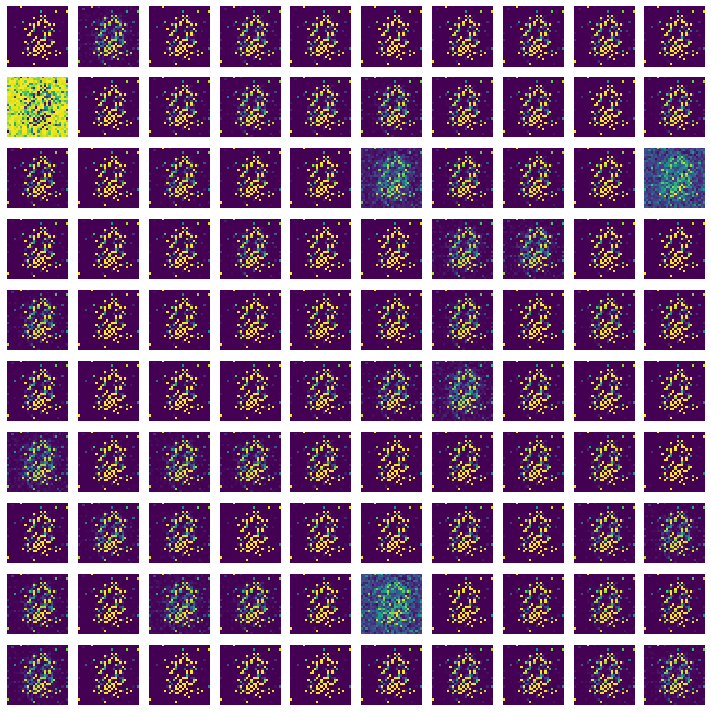

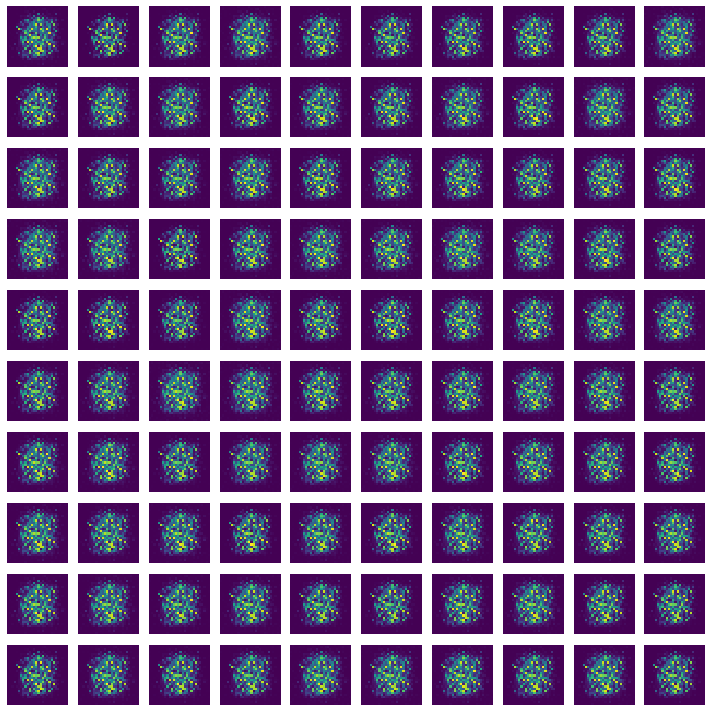

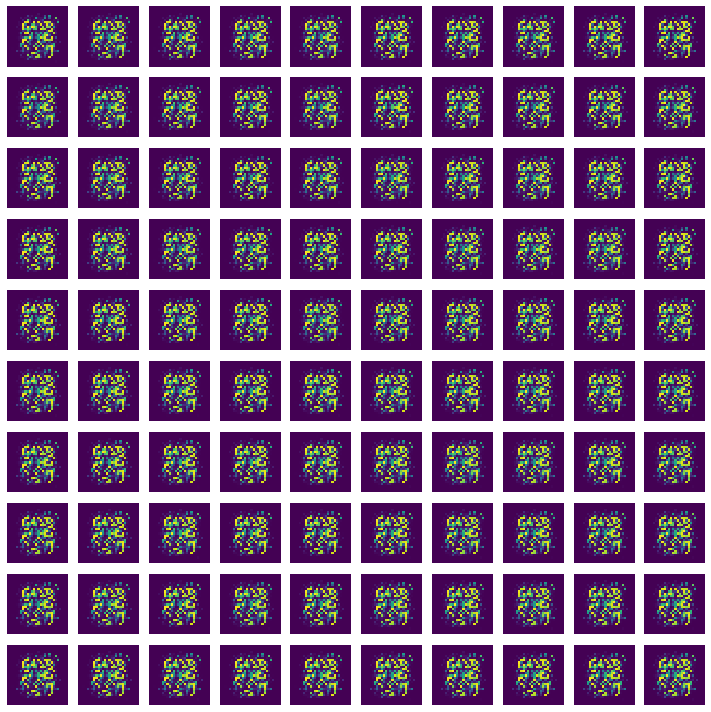

In [19]:
training(50,128)